<a href="https://colab.research.google.com/github/bksat90/ImageSegmentation/blob/main/Image_Segmentation_DeepLabV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installation of KerasCV.
!pip install -q --upgrade keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.8 MB/s eta 0:00:00


In [ ]:
# import libraries
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import skimage.io as io
# import matplotlib
# import matplotlib.patches as patches
# import matplotlib.colors as colors
# import seaborn as sns
import keras
import keras_cv
import tensorflow as tf

from keras import layers
from random import shuffle
from PIL import Image
from pycocotools.coco import COCO
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from keras.layers import *
from keras.optimizers import *

%matplotlib inline

Using TensorFlow backend


In [ ]:
# Import and mount Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Unzip the dataset file and store it in a folder called images.
!unzip "/content/drive/MyDrive/RMiDS/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/RMiDS/coco2017/"

Archive:  /content/drive/MyDrive/RMiDS/RM_Segmentation_Assignment_dataset.zip
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001751.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001380.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001643.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001583.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001685.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001482.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001494.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001551.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001654.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001594.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001411.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/00000

In [ ]:
# create required folders
os.chdir('/content/drive/MyDrive/RMiDS/coco2017/train-300')
# os.mkdir('resized')
os.mkdir('masked')
# os.mkdir('maskresized')

os.chdir('/content/drive/MyDrive/RMiDS/coco2017/validation-300')
# os.mkdir('resized')
os.mkdir('masked')
# os.mkdir('maskresized')

In [ ]:
# Load paths for the COCO dataset annotation files
train_data_path = "/content/drive/MyDrive/RMiDS/coco2017/train-300"
train_annotation_file = f"{train_data_path}/labels.json"
coco_train = COCO(train_annotation_file)

val_data_path = "/content/drive/MyDrive/RMiDS/coco2017/validation-300"
val_annotation_file = f"{train_data_path}/labels.json"
coco_val = COCO(val_annotation_file)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [ ]:
def EDAbar(coco):
  """This function generates exploratory data analysis in bar chart
     coco - object for train or test data set
  """

  targets = ["cake", "car", "dog", "person"]
  # load the categories
  cIDs = coco.getCatIds(catNms=targets)
  cats = coco.loadCats(cIDs)

  # category names
  cat_names = [cat['name'].title() for cat in cats]

  # Get category counts
  cat_counts = [coco.getImgIds(catIds=[cat['id']]) for cat in cats]
  cat_counts = [len(img_ids) for img_ids in cat_counts]

  plt.figure()
  plt.bar(cat_names, cat_counts, align="center", color="blue")
  plt.xlabel('Count',fontsize=10)
  plt.ylabel('Categories',fontsize=10)
  plt.title('Categories in COCO Dataset',fontsize=10)

  plt.show()

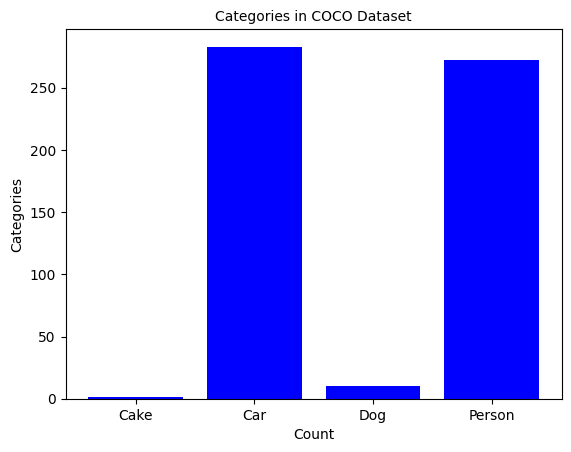

In [ ]:
# EDA for training data set
EDAbar(coco_train)

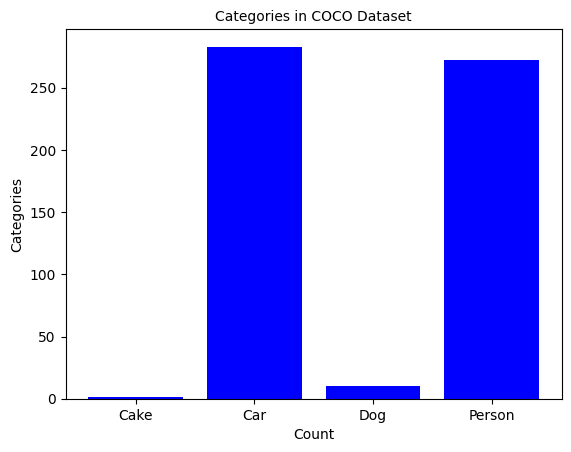

In [ ]:
# EDA for training data set
EDAbar(coco_val)

In [ ]:
target_classes = ["cake", "car", "dog", "person"]
catIds_train = []
imgDict_train = []
imgIds_train = []

catIds_val = []
imgDict_val = []
imgIds_val = []

# Iterate over each individual class in the list
for class_name in target_classes:
    # training data set
    temp1 = coco_train.getCatIds(catNms=class_name)
    catIds_train += temp1
    temp2  = coco_train.getImgIds(catIds=temp1)
    if temp2 not in imgIds_train:
        imgIds_train += temp2
        imgDict_train += coco_train.loadImgs(temp2)

    # test data set
    temp3 = coco_val.getCatIds(catNms=class_name)
    catIds_val += temp3
    temp4 = coco_val.getImgIds(catIds=temp3)
    if temp4 not in imgIds_val:
        imgIds_val += temp4
        imgDict_val += coco_val.loadImgs(temp4)

In [ ]:
# Print the number of training and validation images and categories
print(len(imgIds_train), len(catIds_train))
print(len(imgIds_val), len(catIds_val))

566 4
566 4


In [ ]:
# Generate the list of file names for training and validation person images
train_images_list = []
val_images_list = []

In [ ]:
# Initialize a count variable
count = 0

# Generate the masks for training images
for ID in imgIds_train:

    # Retrieve a random image ID from the training set
    sampleImgIds = coco_train.getImgIds(imgIds=[ID])
    sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # Retrieve the annotation IDs and annotations for the image
    annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
    anns = coco_train.loadAnns(annIds)

    # Generate the mask by combining the individual instance masks
    mask = coco_train.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_train.annToMask(anns[i])

    if sampleImgDict['file_name'] not in train_images_list:
        train_images_list.append(sampleImgDict['file_name'])

    # Set the file path for the mask
    file_path = "/content/drive/MyDrive/RMiDS/coco2017/train-300/masked/" + sampleImgDict['file_name']

    # Convert the mask to an image and save it
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)
    count = count + 1

In [ ]:
# Reset the count variable
count = 0

# Generate the masks for validation images
for ID in imgIds_val:

    # Retrieve a random image ID from the validation set
    sampleImgIds = coco_val.getImgIds(imgIds=[ID])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # Retrieve the annotation IDs and annotations for the image
    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_val, iscrowd=0)
    anns = coco_val.loadAnns(annIds)

    # Generate the mask by combining the individual instance masks
    mask = coco_val.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_val.annToMask(anns[i])

    if sampleImgDict['file_name'] not in val_images_list:
        val_images_list.append(sampleImgDict['file_name'])

    # Set the file path for the mask
    file_path = "/content/drive/MyDrive/RMiDS/coco2017/validation-300/masked/" + sampleImgDict['file_name']

    # Convert the mask to an image and save it
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)

    count = count + 1

In [ ]:
def readimages(folder_path, img_list):
    size = 128
    data = []

    for file in img_list:
        # Create the image path
        img_path = os.path.join(folder_path, file)
        # Read in the images
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        # Change BGR colour default from cv2 to RGB used in matplotlib.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize the images.
        img = cv2.resize(img, (size, size))
        data.append(img)

    # Convert the data from a list to a NumPy array.
    return np.array(data)

In [ ]:
def readgrayimages(folder_path, img_list):
    size = 128
    data = []

    for file in img_list:
        # Create the image path
        img_path = os.path.join(folder_path, file)
        # Read in the images
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Resize the images.
        img = cv2.resize(img, (size, size))
        data.append(img)

    # Convert the data from a list to a NumPy array.
    return np.array(data)

In [ ]:
train_loc = '/content/drive/MyDrive/RMiDS/coco2017/train-300/data'
mask_loc = '/content/drive/MyDrive/RMiDS/coco2017/train-300/masked'

In [ ]:
img_list = sorted(train_images_list)

In [ ]:
train_images = readimages(train_loc, img_list)
mask_images = readgrayimages(mask_loc, img_list)

In [ ]:
mask_images.shape

(300, 128, 128)

In [ ]:
mask_images = mask_images.reshape(300, 128, 128, 1)

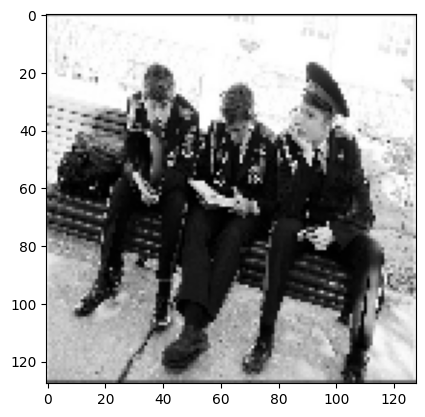

In [ ]:
plt.imshow(train_images[8])

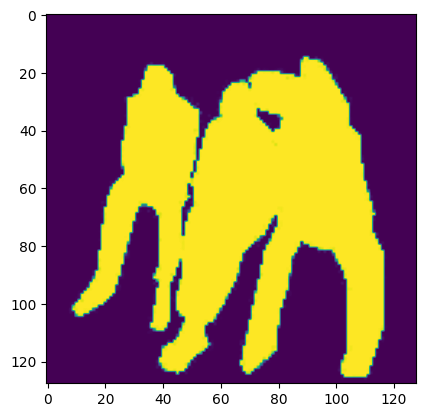

In [ ]:
plt.imshow(mask_images[8])

In [ ]:
tr_images = train_images / 255.0
mk_images = mask_images / 255.0

In [ ]:
backbone = keras_cv.models.ResNet50V2Backbone(input_shape=[128, 128, 3])
model = keras_cv.models.segmentation.DeepLabV3Plus(
    num_classes=1, backbone=backbone,
)


# model = keras_cv.models.DeepLabV3Plus.from_preset(preset="resnet50_imagenet",
#                                                   load_weights=True,
#                                                   input_shape=[128, 128, 3],
#                                                   num_classes=1)

100%|██████████| 871/871 [00:00<00:00, 1.70MB/s]


In [ ]:
model.compile(
    optimizer="adam",
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [ ]:
model.fit(train_images, mask_images, epochs=10)

Epoch 1/10


10/10 [==============================] - 140s 4s/step - loss: -103.8954 - accuracy: 0.0036
Epoch 2/10
10/10 [==============================] - 6s 621ms/step - loss: -268.5295 - accuracy: 0.0036
Epoch 3/10
10/10 [==============================] - 6s 616ms/step - loss: -420.4069 - accuracy: 0.0036
Epoch 4/10
10/10 [==============================] - 6s 614ms/step - loss: -541.8666 - accuracy: 0.0036
Epoch 5/10
10/10 [==============================] - 6s 610ms/step - loss: -625.8005 - accuracy: 0.0036
Epoch 6/10
10/10 [==============================] - 6s 607ms/step - loss: -787.7767 - accuracy: 0.0036
Epoch 7/10
10/10 [==============================] - 6s 607ms/step - loss: -960.2985 - accuracy: 0.0036
Epoch 8/10
10/10 [==============================] - 6s 606ms/step - loss: -1138.7588 - accuracy: 0.0036
Epoch 9/10
10/10 [==============================] - 6s 607ms/step - loss: -1338.4221 - accuracy: 0.0036
Epoch 10/10
10/10 [==============================] - 6s 606ms/step - loss: -1526.96

In [ ]:
x = model.predict(train_images)

10/10 [==============================] - 3s 173ms/step


In [ ]:
x = (x > 0.2).astype(np.uint8)

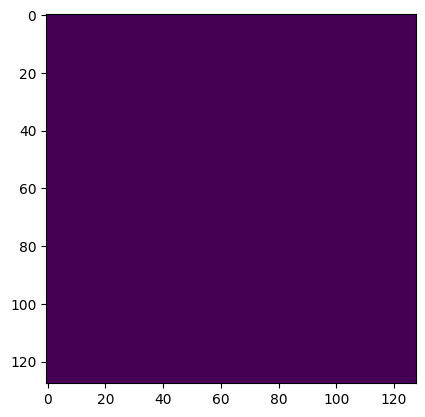

In [ ]:
plt.imshow(x[8])